# Testing DEMV on _Contraceptive Method Choice_ dataset

Source: [https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)

- Label: `contr_use`
- Unprivileged group: `wife_religion=1 (islam) & wife_work=1 (non-work)`
- Positive label: `2 (long-term)`

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('data2/cmc.data', names=['wife_age', 'wife_edu', 'hus_edu', 'num_child', 'wife_religion', 'wife_work', 'hus_occ', 'living', 'media', 'contr_use'])
data

,wife_age,wife_edu,hus_edu,num_child,wife_religion,wife_work,hus_occ,living,media,contr_use
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [3]:
label = 'contr_use'
sensitive_features = ['wife_religion', 'wife_work']
unpriv_group = {'wife_religion': 1, 'wife_work': 1}
positive_label= 2

In [4]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased dataset

In [5]:
model, bias_metrics, pred = cross_val2(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [6]:
print_metrics(bias_metrics)

Statistical parity:  -0.126  +-  0.032
Disparate impact:  0.494  +-  0.121
Zero one loss:  0.33  +-  0.147
F1 score:  0.517  +-  0.039
Accuracy score:  0.521  +-  0.038


## DEMV dataset

In [7]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [8]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [9]:
print_metrics(demv_metrics)

Statistical parity:  0.012  +-  0.061
Disparate impact:  0.671  +-  0.163
Zero one loss:  0.226  +-  0.115
F1 score:  0.505  +-  0.039
Accuracy score:  0.513  +-  0.037


## DEMV Evaluation

In [10]:
eval_data = data.copy()

In [11]:
demv.get_iters()

15

In [12]:
metrics = eval_demv(3, demv.get_iters(), eval_data, pipeline, label, unpriv_group, sensitive_features, positive_label)

Execution time: ~6min

## Blackbox PostProcessing

In [13]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [14]:
data.loc[:,"combined"] = 0
data.loc[(data['wife_religion'] == 1) & (data["wife_work"] == 1),"combined"] = 1

In [15]:
#Now pred has the actual values on column "y_true" and predicted values on column "contr_use"

pred.loc[:,"combined"] = 0
pred.loc[(pred['wife_religion'] == 1) & (pred["wife_work"] == 1),"combined"] = 1

In [16]:
y_pred = pred[label].values
y_true = pred['y_true'].values

In [17]:
import tools
stats = tools.clf_metrics(y_true, y_pred)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,285.0,252.0,699.0,237.0,0.5214,0.7244,0.5173,0.7394,0.2458,0.5165,0.2508,0.3319,0.0,0.0,521.0,537.0,16.0,-0.0


In [20]:
blackboxmetrics = blackboxCVmetrics( data, label, y_true, unpriv_group, pred )


Pre-adjustment group rates are 

0
      fpr     tpr
1  0.2500  0.7273
2  0.1579  0.5000
3  0.2632  0.3750

1
      fpr     tpr
1  0.2593  0.6500
2  0.1026  0.5625
3  0.2500  0.6053


And loss is 0.4054


Pre-adjustment group rates are 

0
      fpr     tpr
1  0.2500  0.7895
2  0.1818  0.5000
3  0.2121  0.3571

1
      fpr     tpr
1  0.2653  0.6757
2  0.1096  0.5385
3  0.2200  0.6111


And loss is 0.3910

[0.60495397 0.18451971 0.21052632]
[0.26844002 0.4753938  0.25616618]
[0.20663404 0.40032556 0.3930404 ]
[0.60495397 0.1719141  0.22313192]
[0.27548673 0.4753938  0.24911947]
[0.22383297 0.38312663 0.3930404 ]

Pre-adjustment group rates are 

0
      fpr     tpr
1  0.2593  0.7273
2  0.1143  0.4286
3  0.2778  0.4615

1
      fpr     tpr
1  0.2449  0.6286
2  0.1029  0.5625
3  0.2745  0.6061


And loss is 0.4060

[0.62367984 0.10359289 0.27272727]
[0.26892577 0.32340565 0.40766857]
[0.21506362 0.23584099 0.54909539]
[0.62367984 0.09835476 0.2779654 ]
[0.24805448 0.32340565 0.42853986]


## Plot

In [21]:
df = prepareplots(metrics,'cmc')

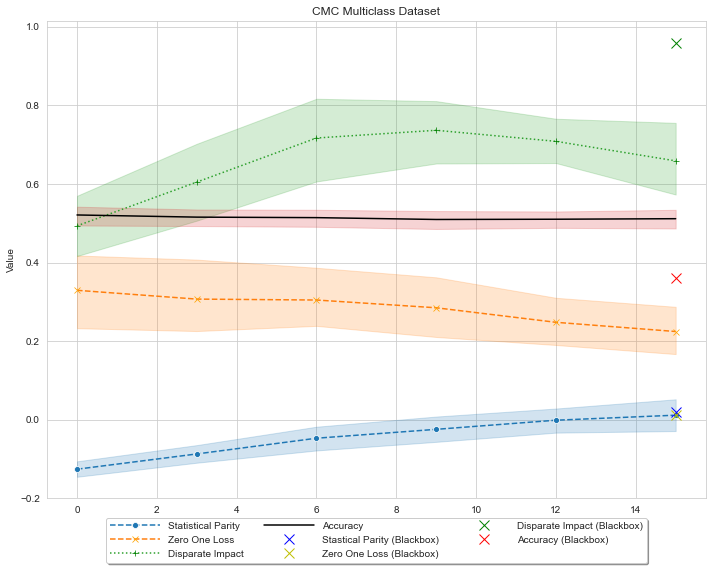

In [22]:
points = preparepoints(blackboxmetrics, demv.get_iters())
plot_metrics_curves(df, points, title='CMC Multiclass Dataset')

In [23]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 1473
Unprivileged group size: 955
Percentage of unprivileged group: 64.8336727766463
Number of iterations: 15
